<a href="https://colab.research.google.com/github/cwlanyon/CardiacDTWorkshop/blob/main/Gaussian_Process_Emulators_For_Cardiac_Digital_Twins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting started with Gaussian process emulators

This lab is designed to introduce Gaussian process emulation in a practical way using the Python package GPyTorch and the Modular Circ cardiac model.

This lab session is intended to be introductory in nature due to the varied scientific backgrounds of the attendees. It involves visualising samples from Gaussian process priors, loading and normalising a datasets, learning a GP surrogate function for a cardiac digital twin and testing different GP kernel functions to assess emulator accuracy.

In [ ]:
!pip install gpytorch # Installs the gpytorch package for generating Gaussian process models

In [ ]:
!pip install ModularCirc # Installs the ModularCirc package for running cardiac models

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.9/292.9 kB 7.2 MB/s eta 0:00:00
  Created wheel for tdqm: filename=tdqm-0.0.1-py3-none-any.whl size=1322 sha256=5b3b0db6122cd62b18b8fd07dc451add0eb525000baaa26cd0c26db06112fea2
  Stored in directory: /root/.cache/pip/wheels/af/02/71/aae0f7ee738abf19498353918ddae0f90a0d6ceb337b0bbc91
Successfully built tdqm


In [ ]:
# Load important modules
# Support for maths
import numpy as np
import torch

# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

# For splitting training and testing data
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# For running the Modular Circ cardiac digital twin
import ModularCirc

#GpyTorch Gaussian Process library
import gpytorch as gpt


# Displaying images from URLs
from PIL import Image
from IPython.display import display
import urllib.request
from io import BytesIO

The documentation for GPyTorch is avilable at https://docs.gpytorch.ai/en/stable/. We will be using GPyTorch to define our kernels, mean functions and GP models. Training the GP models is done externally using the ADAM optimiser in pytorch.

### Covariance functions, aka kernels

We will define a covariance function, from hereon referred to as a kernel, using `GPyTorch`. The most commonly used kernel in machine learning is the Gaussian-form radial basis function (RBF) kernel. It is also commonly referred to as the exponentiated quadratic or squared exponential kernel &ndash; all are equivalent.

The definition of the (1-dimensional) RBF kernel has a Gaussian-form, defined as:

$$
    \kappa_\mathrm{rbf}(x,x') = \sigma^2\exp\left(-\frac{(x-x')^2}{2\mathscr{l}^2}\right)
$$

It has two parameters, described as the variance, $\sigma^2$ and the lengthscale $\mathscr{l}$.

In GPyTorch, we define our kernels using kernel modules. The basic RBF kernel does not include the variance parameter, $\sigma^2$. To build a kernel with both lengthscale and variance parameters we need to wrap RBFKernel function inside of a ScaleKernel (this provides the variance parameter, $\sigma^2$).

In [ ]:
# Here we define an RBF kernel with both lengthscale and variance parameters
RBF_covar_module = gpt.kernels.ScaleKernel(gpt.kernels.RBFKernel())

This kernel has been instantiated with the default GPyTorch parameters (usually $\ln(2)$), we can check them by calling them from the covariance module.

Note that, because we generated our kernel by wrapping an unscaled RBF inside a scale kernel, we can call the variance or "outputscale" directly from the covariance module, but to call the lengthscale we need to access "base_kernel".

In [ ]:
RBF_covar_module.outputscale

tensor(0.6931, grad_fn=<SoftplusBackward0>)

In [ ]:
RBF_covar_module.base_kernel.lengthscale

tensor([[0.6931]], grad_fn=<SoftplusBackward0>)

If we want to change the kernel variables we can set them ourselves

In [ ]:
RBF_covar_module.outputscale=1
RBF_covar_module.base_kernel.lengthscale=1

print("The variance is now",RBF_covar_module.outputscale.tolist(),"and the lengthscale is now",RBF_covar_module.base_kernel.lengthscale.tolist())

The variance is now 1.0 and the lengthscale is now [[1.0]]


Kernels can be combined using the "+" and "*" operators. Let's generate a scaled additive combination of the RBF and Matern 5/2 kernels. To do this we add a MaternKernel object and include the parameter nu=2.5 (for the 5/2).

In [ ]:
Additive_covar_module = gpt.kernels.ScaleKernel(gpt.kernels.RBFKernel()+gpt.kernels.MaternKernel(nu=2.5))

To access the hyper-parameters we have to slightly change our code to account for the combined kernels. Below we access the Matern kernel lengthscale by calling the second kernel within the "base_kernel" object.

Python indexing begins at 0, so to access the second kernel we use index 1.

In [ ]:
Additive_covar_module.base_kernel.kernels[1].lengthscale

tensor([[0.6931]], grad_fn=<SoftplusBackward0>)

For more information on all the different types of kernel and their input parameters see the documentation here: https://docs.gpytorch.ai/en/v1.12/kernels.html

### Visualising the kernel

We can visualise our kernel in a few different ways. We can plot the _shape_ of the kernel by plotting $k(x,0)$ over some sample space $x$ which, looking at the equation above, clearly has a Gaussian shape. This describes the covariance between each sample location and $0$.

Alternatively, we can construct a full covariance matrix, $\mathbf{K}_{xx} \triangleq k(x,x')$ (with samples $x = x'$, generating a diagonal matrix). The resulting GP prior is a multivariate normal distribution over the space of samples $x$: $N(\mathbf{0}, \mathbf{K}_{xx})$. It should be evident then that the elements of the matrix represents the covariance between respective points in $x$ and $x'$, and that it is exactly $\sigma^2[=1]$ in the diagonal.

We can show this using `pyplot` to plot the vector $k(x,0)$ and the matrix $k(x,x')$:

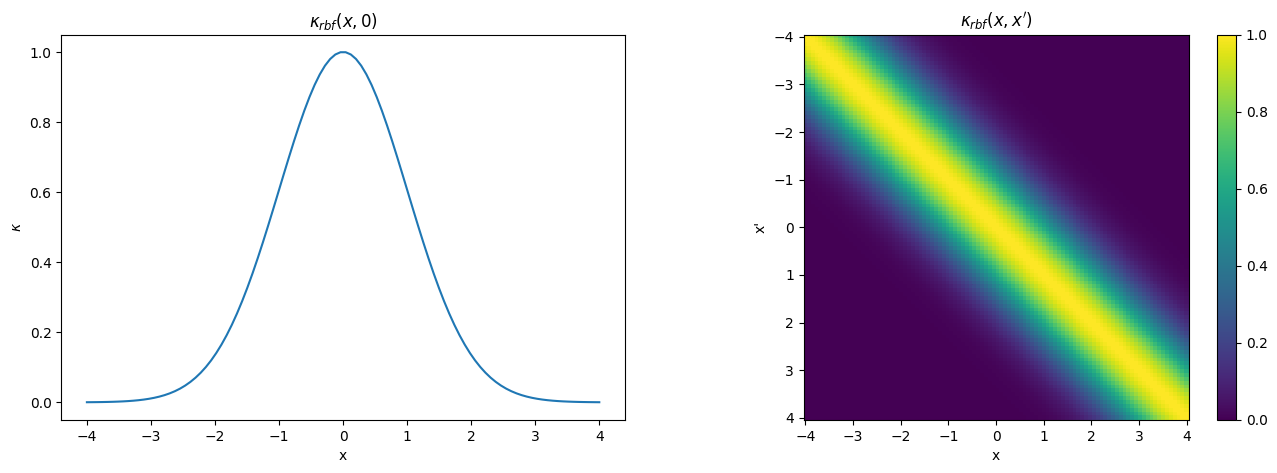

In [ ]:
# Our sample space: 100 samples in the interval [-4,4]
x1 = torch.linspace(-4.,4.,100)
covar_1D = RBF_covar_module(x1,torch.tensor([0])) # Returns a RootLinearOperator, an object used to ease the computational burden of linear algebra

# Gets the actual tensor for this kernel matrix using .to_dense()
#we use detach().numpy() to remove the gradient and convert to a numpy array for plotting
tensor_1D = covar_1D.to_dense().detach().numpy()

covar_2D = RBF_covar_module(x1) # Returns a RootLinearOperator
tensor_2D = covar_2D.to_dense().detach().numpy() # Gets the actual tensor for this kernel matrix

# Set up the plotting environment
plt.figure(figsize=(16,5))

# ==== k(x,0)

plt.subplot(121) # left plot

# Plot covariance vector
plt.plot(x1.detach().numpy(),tensor_1D)

# Annotate plot
plt.xlabel("x"), plt.ylabel("$\kappa$")
plt.title("$\kappa_{rbf}(x,0)$")

# ==== k(x,x')

plt.subplot(122) # right plot

# Plot the covariance of the sample space
plt.pcolor(x1.T.detach().numpy(), x1.detach().numpy(), tensor_2D)

# Format and annotate plot
plt.gca().invert_yaxis(), plt.gca().axis("image")
plt.xlabel("x"), plt.ylabel("x'"), plt.colorbar()
plt.title("$\kappa_{rbf}(x,x')$");

We can also visualise how the kernel parameters affect the kernel function, below we vary the lengthscale, $l$:

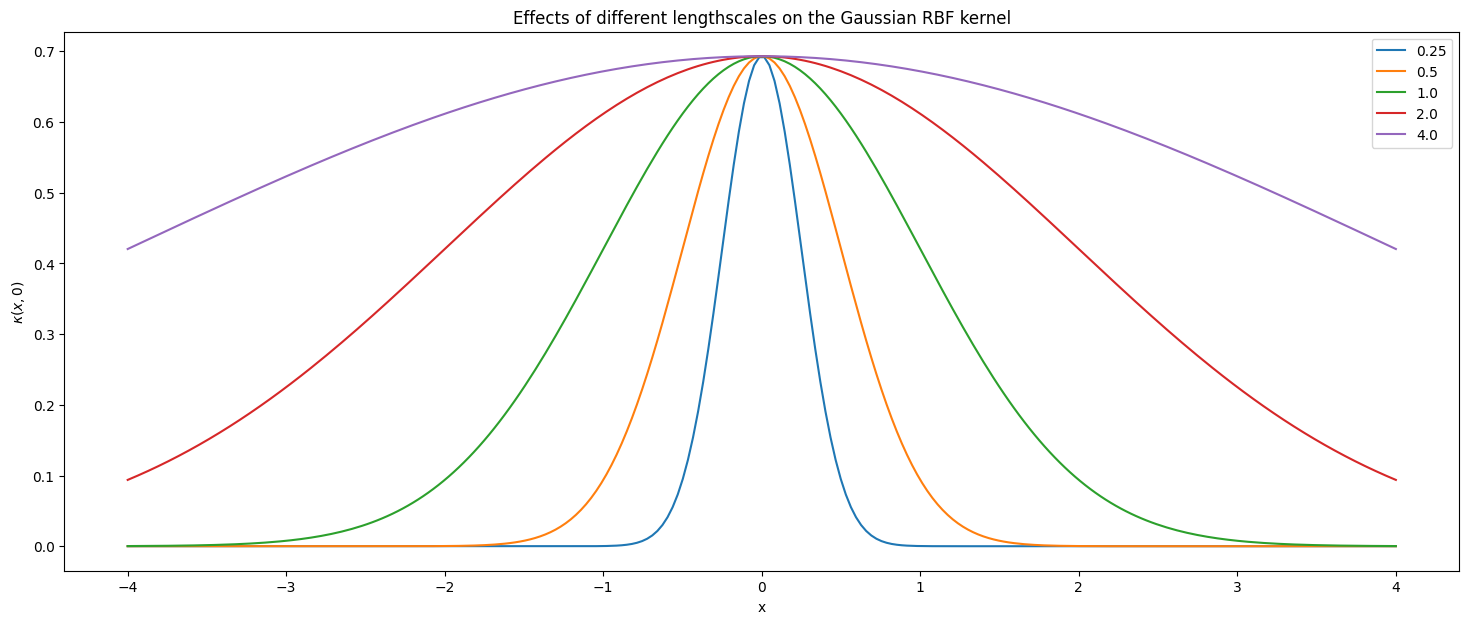

In [ ]:
# Our sample space : 100 samples in the interval [-4,4]
X = torch.linspace(-4.,4.,250) # we use more samples to get a smoother plot at low lengthscales

# Create a 1-D RBF kernel with default parameters
covar_module = gpt.kernels.ScaleKernel(gpt.kernels.RBFKernel())

# Set up the plotting environment
plt.figure(figsize=(18, 7))

# Set up our list of different lengthscales
ls = [0.25, 0.5, 1., 2., 4.]

# Loop over the lengthscale values
for l in ls:
    # Set the lengthscale to be l
    covar_module.base_kernel.lengthscale = l
    # Calculate the new covariance function at k(x,0)
    covar_1D = covar_module(X,torch.tensor([0])) # Returns a RootLinearOperator
    C= covar_1D.to_dense().detach().numpy()
    # Plot the resulting covariance vector
    plt.plot(X,C)

# Annotate plot
plt.xlabel("x"), plt.ylabel("$\kappa(x,0)$")
plt.title("Effects of different lengthscales on the Gaussian RBF kernel")
plt.legend(labels=ls);

### Exercise 1

(a) What is the effect of the lengthscale parameter on the covariance function?

(b) Change the code used above to plot the covariance function showing the effects of the variance on the covariance function. Comment on the effect.

## 2. Types of covariance function

There are many different covariance functions already implemented in `GPy`. Aside from the `RBF` kernel, there are others such as the following:
- `Cosine`
- `Matern`
- `Polynomial`
- `Linear`

You can also combine kernels using the `additive` and `structure` kernels. Adding and multiplying kernels can be acheived simply by using the "+" and "*" operators.

See the docs here: https://docs.gpytorch.ai/en/v1.14/kernels.html

Note: when defining these, all are preceded by `gpt.kernels.` The following are some examples of the [Matérn 5/2](https://en.wikipedia.org/wiki/Mat%C3%A9rn_covariance_function) and Cosine kernels, compared with the RBF kernel:

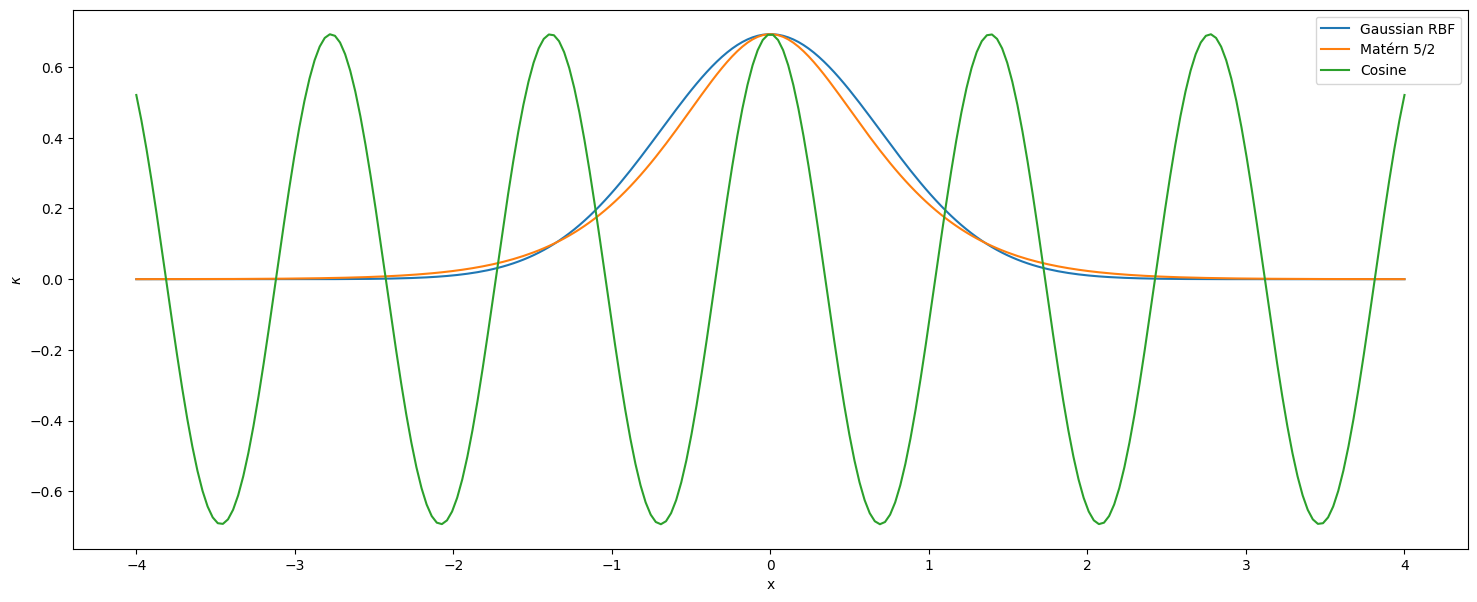

In [ ]:
# Our sample space : 100 samples in the interval [-4,4]
X = torch.linspace(-4.,4.,250)

# RBF kernel
k_R = gpt.kernels.ScaleKernel(gpt.kernels.RBFKernel())
C_R = k_R(X, torch.tensor([[0.]])).to_dense().detach().numpy()

# Matern 5/2
k_M = gpt.kernels.ScaleKernel(gpt.kernels.MaternKernel(nu=2.5))
C_M = k_M(X, torch.tensor([[0.]])).to_dense().detach().numpy()

# Cosine
k_C = gpt.kernels.ScaleKernel(gpt.kernels.CosineKernel())
C_C = k_C(X, torch.tensor([[0.]])).to_dense().detach().numpy()

plt.figure(figsize=(18,7))
plt.plot(X, C_R, X, C_M, X, C_C);
plt.xlabel("x"), plt.ylabel("$\kappa$")
plt.legend(labels=["Gaussian RBF", "Matérn 5/2", "Cosine"]);

Not every kernel has the same set of parameters. Some kernels are not parameterised by a lengthscale, for example, like the `Linear` kernel which only has a list of variances corresponding to each linear component

In [ ]:
L=gpt.kernels.LinearKernel(ard_num_dims=3) #Generate a linear kernel with three input dimensions
L.variance #show the variances of each linear component

tensor([[0.6931, 0.6931, 0.6931]], grad_fn=<SoftplusBackward0>)

Likewise, not every kernel is stationary. In the case of the Gaussian RBF, or Matérn kernels, the kernel can be written $\kappa(x,x') = f(x-x')$, however this is not true for, e.g., the polynomial covariance function, which is defined as $k(x,x') = (x^\top x'+c)^d$. This means that the covariance between points depends on the input points themselves.

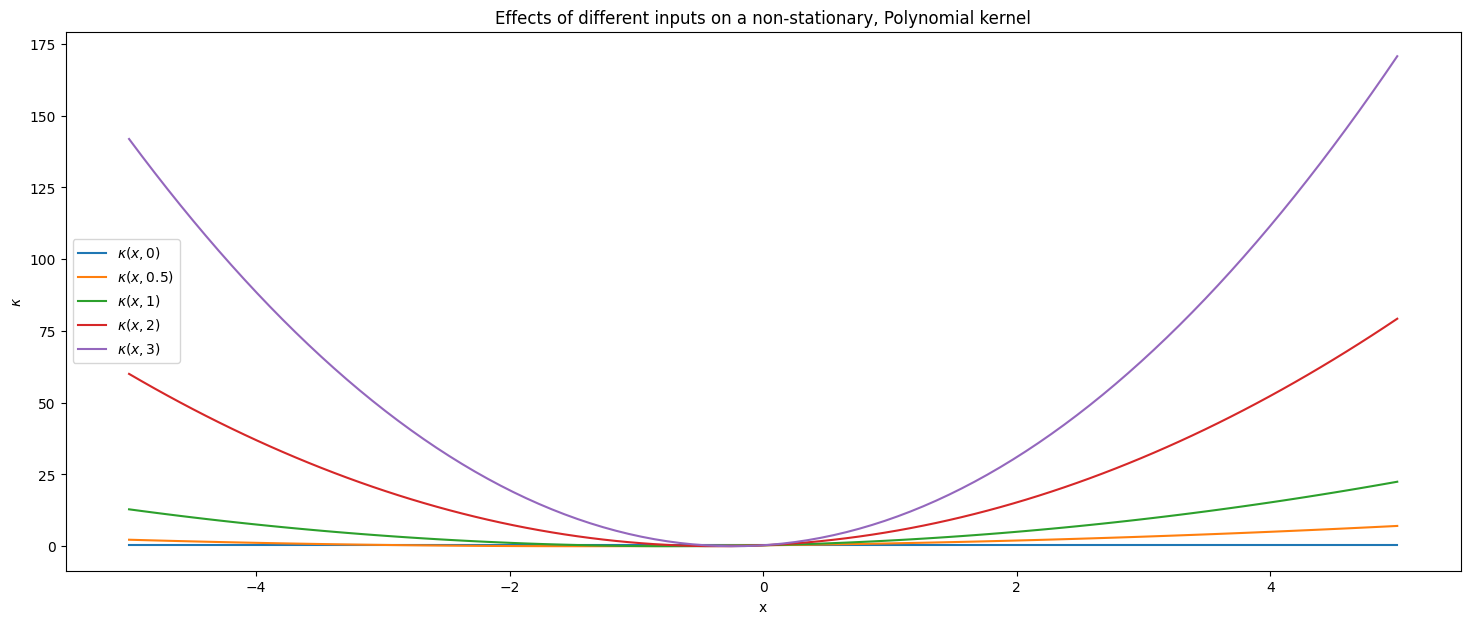

In [ ]:
# Our sample space : 100 samples in the interval [-5,5]
X = torch.linspace(-5., 5., 100)[:,None]

# Note that the Polynomial kernel is defined:
#   k(x,x') = (xTx'+c)^d

# We define our polynomial kernel
k_b = gpt.kernels.ScaleKernel(gpt.kernels.PolynomialKernel(power=2))


plt.figure(figsize=(18,7))

x_s = [0., .5, 1., 2.,3.] # values of x'
# Loop through values of x'
for x_ in x_s:
    # Evaluate kernel at k(x,x')
    K_B = k_b(X, torch.tensor([[x_]])).to_dense().detach().numpy()
    # Plot covariance vector
    plt.plot(X, K_B)

# Annotate plot
plt.xlabel("x"), plt.ylabel("$\kappa$")
plt.title("Effects of different inputs on a non-stationary, Polynomial kernel")
plt.legend(labels=["$\kappa(x,0)$", "$\kappa(x,0.5)$", "$\kappa(x,1)$", "$\kappa(x,2)$", "$\kappa(x,3)$"]);

How might we interpret the covariance structure indicated in the above plot? When might the polynomial kernel be useful?

# Sampling from GP priors

As previously discussed the covariance function determines the prior Gaussian process, let's sample from a prior GP to show how the covariance affects the resulting function space.

To do this we'll need to create a python class with the appropriate mean and covariance functions. You can see more info in the basic GPyTorch regression tutorial: https://docs.gpytorch.ai/en/v1.12/examples/01_Exact_GPs/Simple_GP_Regression.html

In [ ]:
# To sample from the GP prior with GPyTorch we need to define a basic GP class
#We will use the simplest form of GP model, exact inference (as opposed to something like sparse GPs)
# The model is defined by mean and covariance modules

class ExactGPModelRBF(gpt.models.ExactGP): # Define a class of GPs using the GPyTorch exact GP class
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModelRBF, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpt.means.ZeroMean(input_size=1) # Define the mean module
        self.covar_module = gpt.kernels.ScaleKernel(gpt.kernels.RBFKernel()) # Define the covariance module

    def forward(self, x):  # Function to call the mean and covariance when evaluating the model
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpt.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpt.likelihoods.GaussianLikelihood() # Define a gaussian likelihood
#GPyTorch automatically conditions on training data so here we generate a model with empty tensors
model = ExactGPModelRBF(torch.tensor([]), torch.tensor([]), likelihood) # Generate the model with no training data
model.covar_module.base_kernel.lengthscale = 1 # Set the RBF kernel lengthscale to 1

GPyTorch models and likelihoods have two modes, training and evaluation, you can change between them by using ".train()" and ".eval()".

In the training mode you can perform optimisation of the model and likelihood hyperparameters but cannot make predictions or sample from the

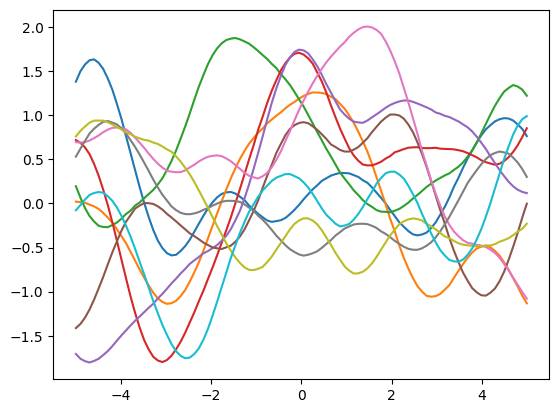

In [ ]:
# Set the model and likelihood to evaluate mode
model.eval()
likelihood.eval()

# Plot samples from the prior
x0=torch.linspace(-5,5,100) # parameter space
plt.plot(x0,model(x0).sample(sample_shape=torch.Size([10],)).T); # plot samples from the GP prior

# Exercise 2

Above we set the kernel lengthscale to 1. What happens if we make the lengthscale larger? Generate samples from a GP with lengthscale=3.

Or shorter? Generate samples from a GP with lengthscale=0.5.

What about if we change the kernel variance? Print the current kernel variance and then generate samples from a GP with an increased variance. Does it behave as you'd expect based on your results from exercise 1.

# Exercise 3

Re-write the code above to sample from GP priors with different covariance functions and visualise the results. In particular, try combining covariance functions and changing the kernel parameters.

For example: Combine a linear kernel with a cosine kernel.

NB: You'll need to create a new GP class with a new covar_module. If you rename the class remember to also change the name in the super argument.

A nice tool for visualising different kernels: https://www.infinitecuriosity.org/vizgp/

Changing the kernel alters the GP prior and you can place points to see the resulting predicted function.

## 3. 1D Gaussian process regression



We've looked at Gaussian process priors and covariance functions. Let's try some Gaussian process regression!

Here we will generate data from a toy function and use it to train a GP emulator.

# Example 1: 1D input, 1D output

Creating an emulator for the function $$f(\theta)=sin(4\theta)+\theta$$ from noisy observations.

$$\theta \in [0,1]$$

Our observational model is $$y_i=f(\theta_i)=g(\theta_i)+\epsilon_i$$ where $$\epsilon_i \sim N(0,\sigma_o^2).$$

We aim to train a gaussian process emulator, $g$, such that $$g(\theta) \approx f(\theta)$$

The hyper-parameters we seek to learn are the GP hyper-parameters and the observation noise variance, $\sigma_o^2$.


In [ ]:
def oneD_func(theta): # define f(theta)
    return torch.sin(4*theta) + theta

In [ ]:
# Set observation upper and lower bounds
lb= -1. # lower bound
ub = 1. # upper bound

p = 5 # Number of observations (more means better emulation)

p2=50

theta_train = torch.linspace(lb,ub,p) # Generate training inputs

y_train=oneD_func(theta_train)

theta_test = torch.linspace(lb,ub,p2) # Generate test inputs

y_test= oneD_func(theta_train)

Let's define a GP model with GPyTorch. We'll use an RBF kernel and a zero mean function.

In [ ]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpt.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpt.means.ZeroMean(input_size=1)
        self.covar_module = gpt.kernels.ScaleKernel(gpt.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpt.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpt.likelihoods.GaussianLikelihood()
model = ExactGPModel(theta_train, y_train, likelihood) #By including the training data we generate a posterior GP

likelihood.eval()
model.eval()

ExactGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ZeroMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

In [ ]:
# Train-test split randomises the data
#here we sort the test data back from min -> max
theta_test=theta_test.sort()[0]

# Predict
predictions_untrained=likelihood(model(theta_test))

We can plot our predictions and uncertainty against the real function.

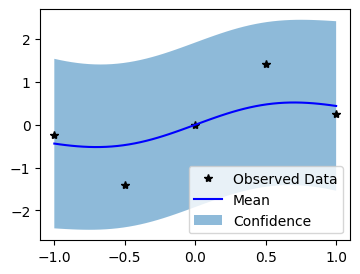

In [ ]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = predictions_untrained.confidence_region()
    # Plot training data as black stars
    ax.plot(theta_train,y_train, 'k*')
    # Plot predictive means as blue line
    ax.plot(theta_test, predictions_untrained.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(theta_test, lower.numpy(), upper.numpy(), alpha=0.5)
    #ax.set_ylim([0, 3])

    ax.legend(['Observed Data', 'Mean', 'Confidence'])

We can also sample from the GP posterior:

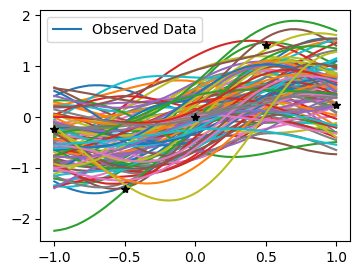

In [ ]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    #ax.set_ylim([0, 3])
    ax.plot(theta_test,model(theta_test).sample(sample_shape=torch.Size([100],)).T);
    # Plot training data as black stars
    ax.plot(theta_train,y_train, 'k*')

    ax.legend(['Observed Data'])

## GP posterior recap

Recall that our prior over observations and targets is jointly Gaussian, using the rule for Gaussian conditionals, the posterior distribution over a set of test points, $$\pi(g(X_*)|y)\sim N(\mu_p,\Sigma_p)$$
where
$$\mu_p =  K(X_*,X)(K(X_*,X)+\sigma_o^2)^{-1}y$$
and
$$K_p = K(X_*,X_*)-K(X_*,X)(K(X,X)+\sigma_o^2)^{-1}K(X,X_*)$$

Though we are yet to optimise any hyperparameters, because GPyTorch automatically generates this posterior, you can see that the GP has already begun to approximate the true function (as opposed to simply sampling from the prior).

However, though our GP posterior mean is approximating the shape of the observed data, our predictions aren't very good. Let's optimise the GP hyper-parameters and the observation noise.

In [ ]:
# Find optimal model hyperparameters


# For ease, define a function to train the emulators using the adam optimiser

def train_model(model,likelihood,y_train,theta_train,training_iter=500):
  # Set model and likelihood to train mode
  model.train()
  likelihood.train()
  # Use the adam optimiser
  optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

  # "Loss" for GPs - the marginal log likelihood
  mll = gpt.mlls.ExactMarginalLogLikelihood(likelihood, model)

  for i in range(training_iter):
      # Zero gradients from previous iteration
      optimizer.zero_grad()
      # Output from model
      output = model(theta_train)
      # Calc loss and backprop gradients
      loss = -mll(output, y_train)
      loss.backward() # generate gradient
      optimizer.step()

train_model(model,likelihood,y_train,theta_train)

Let's take a look at predictions from our optimised model.

In [ ]:
model.eval() # Set model to evaluate mode
likelihood.eval() # Set likelihood to evaluate mode
predictions_trained=likelihood(model(theta_test)) # Generate predictions over the test set


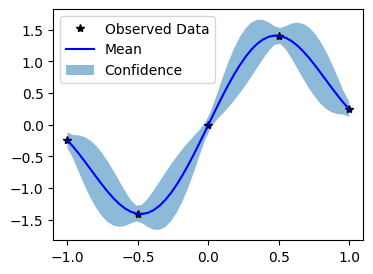

In [ ]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = predictions_trained.confidence_region()
    # Plot training data as black stars
    ax.plot(theta_train,y_train, 'k*')
    # Plot predictive means as blue line
    ax.plot(theta_test, predictions_trained.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(theta_test, lower.numpy(), upper.numpy(), alpha=0.5)
    #ax.set_ylim([0, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

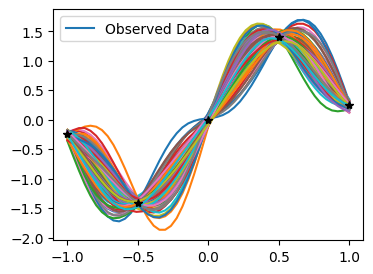

In [ ]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    #Sample from posterior (without likelihood)
    ax.plot(theta_test,model(theta_test).sample(sample_shape=torch.Size([100],)).T);
    # Plot training data as black stars
    ax.plot(theta_train,y_train, 'k*')

    ax.legend(['Observed Data'])

What happens outside of our training range?

In [ ]:
# Let's define a test set over a wider interval
q=200
theta2 = torch.linspace(-2*ub,2*ub,q) # Generate theta={theta_i}
# Predict over the wider interval
predictions_extended=likelihood(model(theta2))

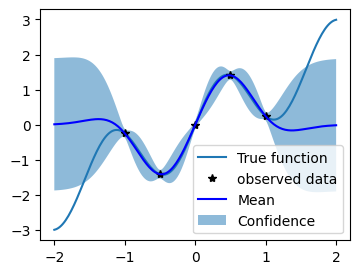

In [ ]:
# Plot the results
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = predictions_extended.confidence_region()
    # Plot training data as black stars
    ax.plot(theta2,oneD_func(theta2))
    ax.plot(theta_train,y_train, 'k*')
    # Plot predictive means as blue line
    ax.plot(theta2, predictions_extended.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(theta2, lower.numpy(), upper.numpy(), alpha=0.5)
    #ax.set_ylim([0, 3])
    ax.legend(['True function','observed data', 'Mean', 'Confidence'])

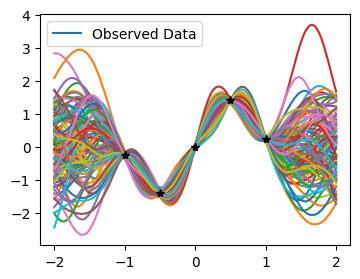

In [ ]:
# Sample from the posterior
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    # Sample from the posterior (without likelihood)
    ax.plot(theta2,model(theta2).sample(sample_shape=torch.Size([100],)).T);
    # Plot training data as black stars
    ax.plot(theta_train,y_train, 'k*')

    ax.legend(['Observed Data'])

# Exercise 4

Train the model using more training points (within the original parameter range) and plot the mean prediction and uncertainty over the extended range.

What effect does that have on the uncertainty?

Does it improve our predictions outside of the training range at all?

Given our knowledge of the function, change the model's kernel function (by addition or multiplication of kernels) to try and increase the extrapolative capability of our model.

# Emulating a cardiac digital twin

In this section we'll put generate simulations from the Naghavi et al. model of left ventricular contractility using the Modular Circ python library. We'll then train a Gaussian process emulator of the model and use it to perform global sensitivity analysis.

The Naghavi model is a 0D lumped parameter model of the circulatory system described in Rapid Estimation of Left Ventricular Contractility with a Physics-Informed Neural Network Inverse Modeling Approach (https://arxiv.org/html/2401.07331v1). The model is comprised of the following components:

LA: linear time-varying elastance model (6 parameters)
MV: non-ideal diode model (1 parameter)
LV: linear time-varying elastance model (5 parameters)
AV: non-ideal diode model (1 parameter)
Aorta: RC Windkessel model (2 parameters)
Vena cava: RC Windkessel model (2 parameters)
Total set of parameters sums up to 17.

The model can be expressed using a circuit diagram:

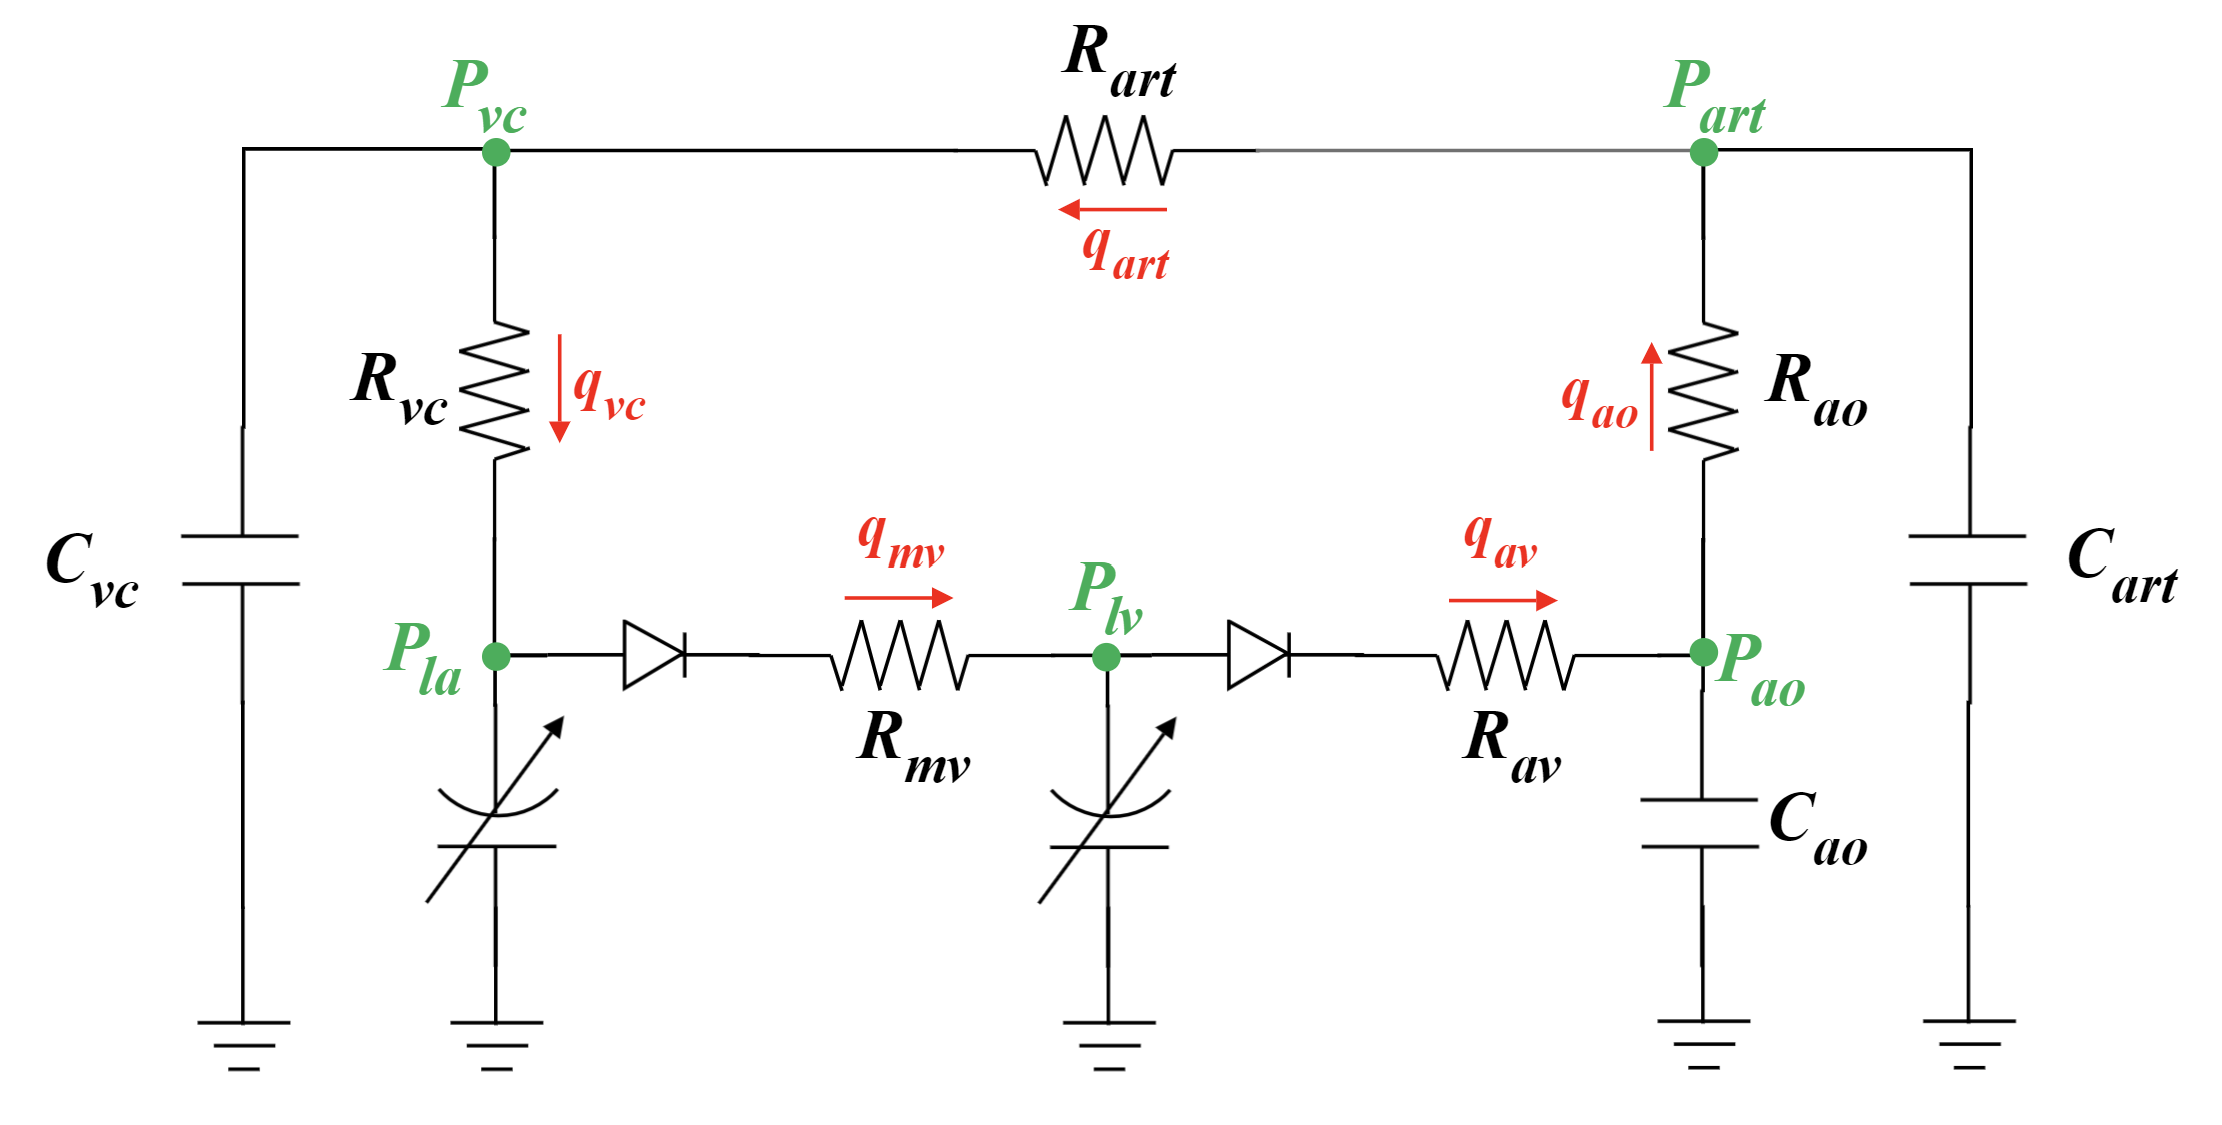

In [ ]:

url = 'https://arxiv.org/html/2401.07331v1/extracted/5346203/Circuit.png'
with urllib.request.urlopen(url) as url:
    img = Image.open(BytesIO(url.read()))

display(img)

To run the model using ModularCirc we need to load a json file that includes the parameters.

In [ ]:
#Load the file from github
!wget https://raw.githubusercontent.com/cwlanyon/CardiacDTWorkshop/refs/heads/main/parameters_01.json

--2025-10-06 10:57:05--  https://raw.githubusercontent.com/cwlanyon/CardiacDTWorkshop/refs/heads/main/parameters_01.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1660 (1.6K) [text/plain]
Saving to: ‘parameters_01.json.1’

parameters_01.json. 100%[===================>]   1.62K  --.-KB/s    in 0s      

2025-10-06 10:57:05 (25.6 MB/s) - ‘parameters_01.json.1’ saved [1660/1660]



To view the file click on the file button on the left. For each parameter you will find a reference value and for those parameters that are varying there is a proportional range within which to vary them.

In this case were are only varying 6 parameters of a possible 17. One might interpret this as "personalising" the model for a patient with some known parameter values.

Next we import the Naghavi model and the batch runner function. This will allow us to sample from the parameter space and run the model for each sample.

In [ ]:
from ModularCirc.Models.NaghaviModel import NaghaviModel, NaghaviModelParameters, TEMPLATE_TIME_SETUP_DICT #Import functions to run the model

In [ ]:
from ModularCirc import BatchRunner # Import the batch runner to run for multiple parameter inputs

In [ ]:
br = BatchRunner('LHS', 0) # Initialise the batch runner with latin-hypercube sampling

In [ ]:
br.setup_sampler('parameters_01.json') #Set up the sampler with our parameters from the json file

In [ ]:
br.sample(100) # Take 100 samples from the parameter space

In [ ]:
br.samples #view the samples, the first six are the varying parameters

,ao.c,art.r,art.c,ven.c,lv.E_act,lv.k_pas,ao.r,ao.l,ao.v_ref,art.l,...,la.tau,la.t_max,lv.E_pas,lv.v_ref,lv.delay,lv.t_tr,lv.tau,lv.t_max,T,v_tot
0,0.400089,739.464899,1.588771,86.622969,2.405602,0.005185,240,0,100,0,...,25,150,1,10,0,420,25,280,800,5000
1,0.268180,948.043164,2.113691,132.053548,2.165524,0.013572,240,0,100,0,...,25,150,1,10,0,420,25,280,800,5000
2,0.402428,1540.872162,2.498110,69.081851,2.524105,0.008051,240,0,100,0,...,25,150,1,10,0,420,25,280,800,5000
3,0.170101,1558.994769,3.659150,123.803330,2.379881,0.010133,240,0,100,0,...,25,150,1,10,0,420,25,280,800,5000
4,0.343154,1626.933628,3.780084,72.007546,1.869434,0.013984,240,0,100,0,...,25,150,1,10,0,420,25,280,800,5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.445876,714.676455,3.323504,100.833577,2.303316,0.014223,240,0,100,0,...,25,150,1,10,0,420,25,280,800,5000
96,0.366219,917.806777,4.428424,131.152304,1.840076,0.019584,240,0,100,0,...,25,150,1,10,0,420,25,280,800,5000
97,0.278746,1343.453596,1.747922,154.900507,3.642344,0.007598,240,0,100,0,...,25,150,1,10,0,420,25,280,800,5000
98,0.323749,1200.115646,3.962173,104.677001,2.793136,0.005615,240,0,100,0,...,25,150,1,10,0,420,25,280,800,5000


In [ ]:
br.setup_model(model=NaghaviModel, po=NaghaviModelParameters, time_setup=TEMPLATE_TIME_SETUP_DICT) # Initialise the model

In [ ]:
# Rescale the timing parameters and map to actual parameters where appropriate.
map_ = {
    'lv.t_tr' : ['lv.t_tr',],
    'la.t_tr' : ['la.t_tr',],
    'la.delay' : ['la.delay',],
    'lv.tau' : ['lv.tau',],
    'la.tau' : ['la.tau',],
    'lv.t_max' : ['lv.t_max',],
    'la.t_max' : ['la.t_max',],
}
br.map_sample_timings(
    ref_time=1000.,
    map=map_
    )

In [ ]:
#use map_vessel_volumes to define the initial distribution of blood in the vessels
br.map_vessel_volume()
br._samples[['ao.v', 'art.v', 'ven.v']].describe().T

,count,mean,std,min,25%,50%,75%,max
ao.v,100.0,12.102837,5.494428,4.081183,8.762906,10.934251,14.881058,27.953211
art.v,100.0,117.251018,44.171364,46.703765,84.533551,107.475840,144.635602,249.705479
ven.v,100.0,4870.646145,46.919597,4723.000770,4841.498949,4880.118230,4904.074633,4949.215052


In [ ]:
# Set up path for output files
import os
path = os.getcwd()
path

'/content'

In [ ]:
# Run the models for our batched parameters (this will take a couple of minutes!)
os.system(f'mkdir -p {path+ "/Outputs/Out_01"}')
all_out = br.run_batch(n_jobs=2, output_path=path+'/Outputs/Out_01') # Creates a list object of the outputs for each run

100%|██████████| 100/100 [03:42<00:00,  2.22s/it]


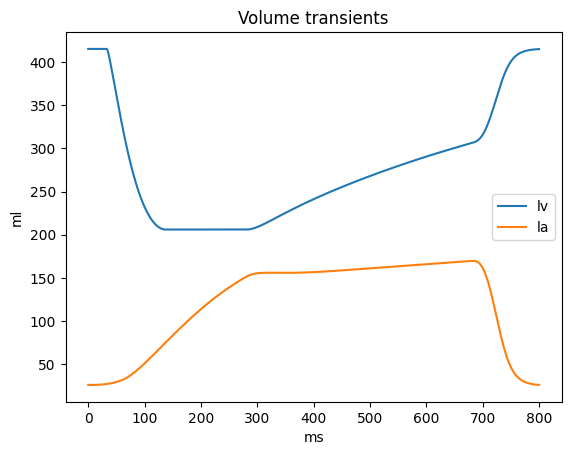

In [ ]:
# We can plot the volume transients for one of the simulations:

ind=0 # set an index

t = all_out[ind].loc[ind]['T'] - all_out[ind].loc[ind]['T'].loc[0] # extract the simulation times

fig, ax = plt.subplots() # initalise the plotting environmemt

ax.plot(t, all_out[ind].loc[ind]['v_lv'], label='lv') # plot the left ventricular volume transient
ax.plot(t, all_out[ind].loc[ind]['v_la'], label='la') # plot the left atrial volume transient

ax.set_xlabel('ms') # label axes
ax.set_ylabel('ml')

ax.legend() # generate legend
ax.set_title('Volume transients')

plt.show()

You can view the outputs in the Out_01 file inside of the Outputs file. Each file contains the pressure, flow and volume transients at each time point of the simulation for each of the heart regions in the model.

In this scenario we want to generate summary statistics that tell us something about the model across the whole time range.

In [ ]:
# Generate summary statistics
max_values = torch.zeros(len(all_out),all_out[0].shape[1])
min_values = torch.zeros(len(all_out),all_out[0].shape[1])
for i in range(len(all_out)): # Loop over each item in all_out
  max_values[i]=torch.tensor(all_out[i].max(axis=0).values)
  min_values[i]=torch.tensor(all_out[i].min(axis=0).values)

diff = max_values-min_values # Calculates max difference between min and max output values

theta = torch.tensor(br.samples.values)[:,0:6] # Select only the varying input parameters

We've got lots of different outputs we could choose from. In the table below "v" refers to volume, "p" to pressure and "q" to flow rates. The suffixes after the underscore are the left ventricle (lv), aorta (ao), peripheral arteries (art), vena cava (vc), and left atrium (la).

In [ ]:
# Output summary from the first run of the batch runner
ind = 0
all_out[ind].loc[ind].describe()

,v_ao,v_art,v_ven,v_la,v_lv,p_lv,q_av,p_ao,p_art,q_ao,p_ven,q_art,p_la,q_ven,q_mv,T
count,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000
mean,204.752998,1216.441847,3378.743012,120.820882,276.241261,85.068703,0.261191,261.824163,199.174008,0.261042,6.681173,0.260314,4.333111,0.260896,0.260958,6000.000000
std,35.107051,33.747422,24.188350,52.041128,66.953131,158.523062,0.792472,87.748079,21.241215,0.347737,0.279237,0.028909,2.698100,0.296798,0.411771,231.286489
min,169.671454,1158.853897,3356.723880,26.074310,206.050581,2.076962,0.000000,174.139838,162.927150,0.044972,6.426978,0.210557,1.028037,-0.800687,0.000000,5600.000000
25%,179.343217,1186.019568,3358.699975,73.726462,214.028934,2.754886,0.000000,198.313861,180.025696,0.052818,6.449790,0.234631,3.114150,0.234585,0.000000,5800.000000
50%,191.263028,1218.325861,3366.559098,155.662159,263.870402,3.624525,0.000000,228.106750,200.359840,0.076763,6.540518,0.262103,3.709753,0.307665,0.206791,6000.000000
75%,217.542036,1248.907352,3399.063206,161.123883,303.957827,42.175674,0.000000,293.789636,219.608362,0.295659,6.915755,0.288053,4.336897,0.395799,0.283165,6200.000000
max,296.617842,1263.047306,3426.792625,169.787650,415.250240,499.231059,3.561223,491.435119,228.508296,1.253707,7.235871,0.300078,13.914514,0.659708,2.144764,6400.000000


In this case we're going to emulate the max aortic volume difference over the timescale, diff[:,0]

In [ ]:
# Use train_test_split to split into training and desting data
theta_train, theta_test, y_train, y_test = train_test_split(
    theta, #inputs
    diff[:,0], #outputs
    test_size=0.2, # proportion (or integer valued) of total data set used for testing
)

To improve training stability and prediction it is often useful to normalise both the input and output data for GPs. Here we normalise everything relative to the training data. This is because, in general, we should treat test data as completely unseen and normalising the entire dataset before the train test split might bias our results.

In [ ]:
# Calculate input mean and standard deviation
y_train_mean = y_train.mean(axis=0)
y_train_std = y_train.std(axis=0)

# Calculate output mean and standard deviation
theta_train_mean = theta_train.mean(axis=0)
theta_train_std = theta_train.std(axis=0)

# Scale training data
theta_train = (theta_train - theta_train_mean)/theta_train_std
y_train = (y_train - y_train_mean)/y_train_std

# Scale testing data inputs
theta_test = (theta_test - theta_train_mean)/theta_train_std

In [ ]:
# Once again we initialise a GP, this time with 6 input parameters
# We use the ard_num_dims argument to vary the lengthscale for each parameter
class ExactGPModel(gpt.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpt.means.ZeroMean(input_size=6)
        self.covar_module = gpt.kernels.ScaleKernel(gpt.kernels.RBFKernel(ard_num_dims=6))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpt.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpt.likelihoods.GaussianLikelihood()
model = ExactGPModel(theta_train, y_train, likelihood)

likelihood.train()
model.train()

ExactGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ZeroMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

Then we train the model

In [ ]:
train_model(model,likelihood,y_train,theta_train)

In [ ]:
# Set the model to evaluate mode
model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

Let's make and evaluate some predictions.

In [ ]:
# Mean prediction
mean_pred=likelihood(model(theta_test)).mean
print(mean_pred)

tensor([ 1.5855, -0.9796, -0.1995,  2.5613, -0.0832,  1.2493,  0.2422,  0.0493,
        -0.3241, -0.1122, -1.1594, -0.2688, -0.7153,  0.4702, -0.9893, -0.6372,
        -0.0279,  1.6831, -0.3668, -1.4821], dtype=torch.float64,
       grad_fn=<ViewBackward0>)


In [ ]:
# True value
y_test

tensor([78.3529, 33.8375, 46.7109, 98.3890, 49.9873, 73.8640, 55.0776, 52.6891,
        44.9715, 49.2355, 31.2625, 44.3039, 39.1992, 59.0705, 34.1302, 39.7813,
        51.4469, 78.3459, 44.6639, 24.1275])

These don't look very similar, but remember, we need to rescale the output of our GP to match the real world scale of the data

In [ ]:
# Rescale the predictions

mean_pred = mean_pred*y_train_std + y_train_mean
print(mean_pred)

tensor([79.3336, 34.1503, 47.8910, 96.5215, 49.9394, 73.4116, 55.6718, 52.2732,
        45.6954, 49.4289, 30.9827, 46.6698, 38.8052, 59.6879, 33.9779, 40.1801,
        50.9131, 81.0525, 44.9446, 25.2983], dtype=torch.float64,
       grad_fn=<AddBackward0>)


That's a bit more like it!

We can evaluate the quality of our emulator more rigorously using the mean squared error and the $R^2$.

For observations $y$ and predictions $y^*$

$$ MSE = \frac{1}{N}\Sigma_n^N(y_n^*-y_n)^2$$


$$ R^2 = 1- \frac{\Sigma_n^N(y_n^*-y_n)^2}{\Sigma_n^N(y_n-\bar{y_n})^2}$$

We'd like MSE to be small (relative to the scale of the data) and $R^2$ to be close to 1.

In [ ]:
# Define MSE and R^2 functions

def MSE(pred,obs):
  mse = ((pred-obs)**2).mean(axis=0)
  return mse

def R2(pred,obs):
  r2=1-MSE(pred,obs)/obs.var(axis=0)
  return r2

In [ ]:
MSE(mean_pred,y_test)

tensor(1.1345, dtype=torch.float64, grad_fn=<MeanBackward1>)

In [ ]:
R2(mean_pred,y_test)

tensor(0.9967, dtype=torch.float64, grad_fn=<RsubBackward1>)

That's pretty good! let's save this model for use later

In [ ]:
torch.save(model.state_dict(), 'model_state.pth')

# Exercise

Try emulating the data with different mean and covariance functions, can we improve the $R^2$?

# 4. Global Sensitivity Analysis (GSA)

GSA is a method for determining which inputs a model is most sensitive to. It is generally a high throughput method that requires many samples from parameter space. In cases where models take a long time to run, emulators are a good fit for performing GSA as they can often evaluate the forward problem very quickly.

Today we'll use the Sobol Indices method of GSA: https://en.wikipedia.org/wiki/Variance-based_sensitivity_analysis

Sobol indices indicate how senstive an output is to its various inputs, based on the output variance as the inputs vary. The higher the Sobol indice, the more sensitive the model is to that parameter.

In [ ]:
# Install the SALib library to perform GSA
!pip install SALib;

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.9/778.9 kB 11.7 MB/s eta 0:00:00


In [ ]:
#Import libraries for sensitivity analysis

import scipy.stats.qmc as qmc
##### from SALib.sample import saltelli
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami

To perform the GSA, let's load the model we saved earlier

In [ ]:
# We need to load the model state dictionary and reinstate the model
# Note that we need include the training data in the loaded model
# This is because GPyTorch conditions the posterior based on the training data

# We initialise a GP class matching our saved GP
class ExactGPModel(gpt.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpt.means.ZeroMean(input_size=6)
        self.covar_module = gpt.kernels.ScaleKernel(gpt.kernels.RBFKernel(ard_num_dims=6))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpt.distributions.MultivariateNormal(mean_x, covar_x)

state_dict = torch.load('model_state.pth')
model = ExactGPModel(theta_train,y_train, likelihood)  # Create a new GP model

model.load_state_dict(state_dict) # Update the new model's parameters to the saved parameters

# Put the model and likelihood into eval mode
model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

Next we can run the sensitivity analysis.

In [ ]:


nDim = theta_train.shape[1] # Number of input parameters
boundsMaxMin = [] # Initialise a list for the max-min bounds of the parameters
for i in range(nDim): # Calculates the max and min bounds of the parameters
    boundsMaxMin.append([np.min(theta_train[:,i].detach().numpy()),np.max(theta_train[:,i].detach().numpy())])

# Define the model inputs
problem = {
    'num_vars': nDim, # Number of parameters
    'names': ['ao.c',	'art.r',	'art.c',	'ven.c',	'lv.E_act',	'lv.k_pas'], # Parameter names
    'bounds': boundsMaxMin # Bounds for each parameter
}

# Generate samples via a saltelli sample
param_values = saltelli.sample(problem, 1024)

data1 = torch.tensor(param_values) #convert to torch for our emulator

#use the emulator to predict the function at the sampled parameter values and rescale the prediction

Ymean=y_train_mean*likelihood(model((data1))).mean+y_train_std

In [ ]:
# Analyse the sobol indices and save the first and total effects

Si=sobol.analyze(problem, Ymean.detach().numpy(), print_to_console=True) # Calculate Sobol indices

total_Si, first_Si, second_Si = Si.to_df()
Si_first =  first_Si.iloc[:,0]
Si_total =  total_Si.iloc[:,0]

                ST   ST_conf
ao.c      0.263602  0.028978
art.r     0.090564  0.012616
art.c     0.049831  0.009003
ven.c     0.066445  0.008623
lv.E_act  0.127792  0.014684
lv.k_pas  0.469587  0.052894
                S1   S1_conf
ao.c      0.241342  0.040981
art.r     0.063654  0.028056
art.c     0.031150  0.016906
ven.c     0.054428  0.020969
lv.E_act  0.121658  0.026698
lv.k_pas  0.427449  0.060117
                            S2   S2_conf
(ao.c, art.r)         0.007944  0.067728
(ao.c, art.c)         0.003569  0.065506
(ao.c, ven.c)         0.005419  0.065411
(ao.c, lv.E_act)      0.008675  0.065284
(ao.c, lv.k_pas)      0.021599  0.075327
(art.r, art.c)        0.011913  0.043590
(art.r, ven.c)        0.016991  0.043411
(art.r, lv.E_act)     0.015168  0.043201
(art.r, lv.k_pas)     0.027915  0.053038
(art.c, ven.c)       -0.003161  0.025935
(art.c, lv.E_act)    -0.002200  0.028879
(art.c, lv.k_pas)     0.012178  0.032172
(ven.c, lv.E_act)    -0.001691  0.034378
(ven.c, lv.k_pas)   

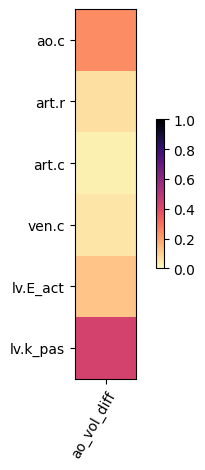

In [ ]:


inputs =  ['ao.c',	'art.r',	'art.c',	'ven.c',	'lv.E_act',	'lv.k_pas']
outputs = ['ao_vol_diff']
fig, ax = plt.subplots()
im = ax.imshow(Si_first.values[:,None],cmap='magma_r',vmin=0,vmax=1)

ax.set_xticks(np.arange(len(outputs)),labels=outputs)
ax.set_yticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

# Exercise

Train a Gaussian process emulator on the total ventricular volume difference (diff[:,2]), test it's accuracy and perform GSA. Do the most important inputs change? Do they change as you'd expect them to?